In [1]:
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

# Get Data

In [ ]:
#The way data is presented on the website, there is no easy to get all of it. 
#So I am going to write a helper functions in case I want to get more data in the future.

In [2]:
def get_data(weeks):
    url = "http://web.mta.info/developers/data/nyct/turnstile/turnstile_{}.txt"
    dfs = []
    for week in weeks:
        file_url = url.format(week)
        dfs.append(pd.read_csv(file_url))
    return pd.concat(dfs)

In [3]:
weeks = [170902, 170916, 170923, 170930, 171007, 171014, 171021, 171028]
turnstile_data = get_data(weeks)

In [4]:
turnstile_data.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,08/26/2017,00:00:00,REGULAR,6303202,2133729
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,08/26/2017,04:00:00,REGULAR,6303225,2133730
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,08/26/2017,08:00:00,REGULAR,6303237,2133753
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,08/26/2017,12:00:00,REGULAR,6303309,2133830
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,08/26/2017,16:00:00,REGULAR,6303508,2133882


In [5]:
#Strip any spaces from column names
turnstile_data.columns = [column.strip() for column in turnstile_data.columns]

#I have done the challenges, and I know that I won't need these columns, so I will drop them right now.
turnstile_data = turnstile_data.drop(["DIVISION", "DESC"], axis=1, errors="ignore")

In [6]:
#Fix the datetime format
turnstile_data['DATETIME'] = turnstile_data['DATE'] + ' ' + turnstile_data['TIME']
turnstile_data['DATETIME'] =  pd.to_datetime(turnstile_data['DATETIME'], format='%m/%d/%Y %H:%M:%S')

In [7]:
turnstile_data.head()

,C/A,UNIT,SCP,STATION,LINENAME,DATE,TIME,ENTRIES,EXITS,DATETIME
0,A002,R051,02-00-00,59 ST,NQR456W,08/26/2017,00:00:00,6303202,2133729,2017-08-26 00:00:00
1,A002,R051,02-00-00,59 ST,NQR456W,08/26/2017,04:00:00,6303225,2133730,2017-08-26 04:00:00
2,A002,R051,02-00-00,59 ST,NQR456W,08/26/2017,08:00:00,6303237,2133753,2017-08-26 08:00:00
3,A002,R051,02-00-00,59 ST,NQR456W,08/26/2017,12:00:00,6303309,2133830,2017-08-26 12:00:00
4,A002,R051,02-00-00,59 ST,NQR456W,08/26/2017,16:00:00,6303508,2133882,2017-08-26 16:00:00


# Data Cleaning

In [8]:
#Sort every entry in LINENAME column to make sure the values are unique alphanumeric combinations.
turnstile_data['LINENAME'] = turnstile_data['LINENAME'].apply(lambda x: ''.join(sorted(x)))

#Remove duplicates.
turnstile_data.drop_duplicates(subset = ['C/A', 'UNIT', 'SCP', 'STATION', 'LINENAME', 'DATETIME'], inplace = True)

#Throw away odd time stamps.
turnstile_data = turnstile_data[turnstile_data['DATETIME'].dt.floor('h') == turnstile_data['DATETIME']]

In [9]:
turnstile_data.head()

,C/A,UNIT,SCP,STATION,LINENAME,DATE,TIME,ENTRIES,EXITS,DATETIME
0,A002,R051,02-00-00,59 ST,456NQRW,08/26/2017,00:00:00,6303202,2133729,2017-08-26 00:00:00
1,A002,R051,02-00-00,59 ST,456NQRW,08/26/2017,04:00:00,6303225,2133730,2017-08-26 04:00:00
2,A002,R051,02-00-00,59 ST,456NQRW,08/26/2017,08:00:00,6303237,2133753,2017-08-26 08:00:00
3,A002,R051,02-00-00,59 ST,456NQRW,08/26/2017,12:00:00,6303309,2133830,2017-08-26 12:00:00
4,A002,R051,02-00-00,59 ST,456NQRW,08/26/2017,16:00:00,6303508,2133882,2017-08-26 16:00:00


In [10]:
def get_daily_counts(df, source_column, counts_column, threshold):
    '''Returns a new dataframe with an additional column which contains entry or exit counts
    based on the parameter passed (exits or entries).'''
    
    temp_df = df.copy()
    temp_df['temp_column'] = (temp_df.
                              groupby(['C/A', 'UNIT', 'SCP', 'STATION', 'LINENAME'])[source_column]
                              .shift().fillna(0)) 
    temp_df[counts_column] = (temp_df['temp_column'] - temp_df[source_column]).abs()
    temp_df = temp_df[temp_df[counts_column] <= threshold]
    del temp_df['temp_column']
    
    return temp_df[1:]

In [11]:
def get_daily_totals(df, source_column):
    '''Returns daily counts for each turnstile for specified column (entries or exits).'''
    return df.groupby(['C/A', 'UNIT', 'SCP', 'STATION', 'LINENAME', 'DATE'])[source_column].sum().reset_index()

In [12]:
#Assuming a person passes a turnstile every 3-4 seconds,
#the maximum number of people passing through a turnstile per 4 hours is 3366.
#So 3366 will be my threshold.
turnstile_daily_counts = get_daily_counts(turnstile_data, 'ENTRIES', 'ENTRY_COUNTS', 3356)

turnstile_daily_totals = get_daily_totals(turnstile_daily_counts, 'ENTRY_COUNTS')

In [13]:
turnstile_daily_totals.head()

,C/A,UNIT,SCP,STATION,LINENAME,DATE,ENTRY_COUNTS
0,A002,R051,02-00-00,59 ST,456NQRW,08/26/2017,514.0
1,A002,R051,02-00-00,59 ST,456NQRW,08/27/2017,539.0
2,A002,R051,02-00-00,59 ST,456NQRW,08/28/2017,1198.0
3,A002,R051,02-00-00,59 ST,456NQRW,08/29/2017,1305.0
4,A002,R051,02-00-00,59 ST,456NQRW,08/30/2017,1393.0


# Plots and Analytics

In [2]:
#We will plot the daily time series for a turnstile.

In [15]:
mask = ((turnstile_daily_totals['SCP']=='02-00-00') & 
        (turnstile_daily_totals['C/A']=='A002') & 
        (turnstile_daily_totals['UNIT']=='R051') &
        (turnstile_daily_totals['STATION'] == '59 ST'))

In [16]:
dates = turnstile_daily_totals[mask]['DATE'].tolist()
counts = turnstile_daily_totals[mask]['ENTRY_COUNTS'].tolist()

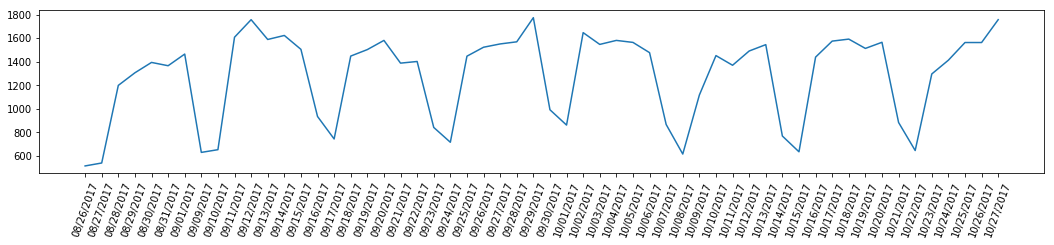

In [17]:
plt.figure(figsize=(18,3))
plt.plot(dates, counts)
plt.xticks(rotation=70);

In [ ]:
#Now combine turnstiles into units and stations.

In [18]:
combo_daily_totals = (turnstile_daily_totals
                      .groupby(['C/A', 'UNIT', 'STATION', 'LINENAME', 'DATE'])['ENTRY_COUNTS']
                      .sum().reset_index())

In [19]:
combo_daily_totals.head()

,C/A,UNIT,STATION,LINENAME,DATE,ENTRY_COUNTS
0,A002,R051,59 ST,456NQRW,08/26/2017,6809.0
1,A002,R051,59 ST,456NQRW,08/27/2017,5608.0
2,A002,R051,59 ST,456NQRW,08/28/2017,11525.0
3,A002,R051,59 ST,456NQRW,08/29/2017,12694.0
4,A002,R051,59 ST,456NQRW,08/30/2017,13064.0


In [20]:
stations_daily_totals = (combo_daily_totals
                        .groupby(['STATION', 'LINENAME', 'DATE'])['ENTRY_COUNTS']
                        .sum().reset_index())

In [21]:
stations_daily_totals.head()

,STATION,LINENAME,DATE,ENTRY_COUNTS
0,1 AV,L,08/26/2017,11897.0
1,1 AV,L,08/27/2017,13321.0
2,1 AV,L,08/28/2017,16840.0
3,1 AV,L,08/29/2017,18255.0
4,1 AV,L,08/30/2017,19005.0


In [22]:
#Because I know some stations and lines have multiple combinations, I am going to combine these columns for my analysis.
stations_daily_totals['STATION_LINENAME'] = stations_daily_totals['STATION'] + ' ' + stations_daily_totals['LINENAME']

In [23]:
#Here, I am creating a dictionary to store available dates and counts as tuples for every station.
station_dict = {}
station_list = stations_daily_totals['STATION_LINENAME'].unique().tolist()

for station in station_list:
    dates = (stations_daily_totals[stations_daily_totals['STATION_LINENAME'] == station])['DATE'].tolist()
    counts = (stations_daily_totals[stations_daily_totals['STATION_LINENAME'] == station])['ENTRY_COUNTS'].tolist()
    station_dict[station] = (dates, counts)

In [ ]:
#Now we can plot the time series for a station.

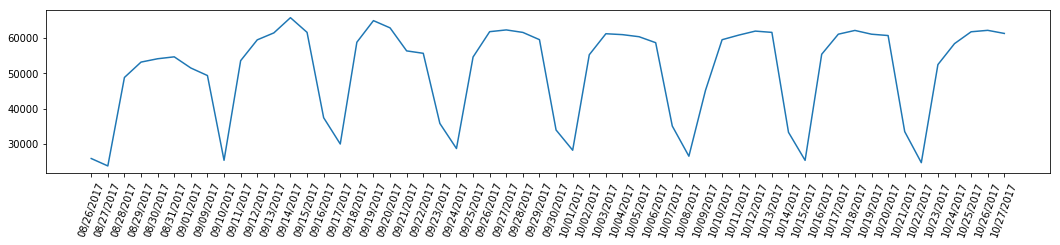

In [24]:
plt.figure(figsize=(18,3))
plt.plot(station_dict['59 ST 456NQRW'][0], station_dict['59 ST 456NQRW'][1])
plt.xticks(rotation=70);

In [ ]:
#Now let's make weekly aggregates.

In [25]:
#I want to see which day of the week my data starts from, so I am going to create a copy of stations_daily_counts,
#convert the date to datetime format, and use datetime functionality to get the days of the week.

weekday_df = stations_daily_totals.copy()
weekday_df['DATE'] = pd.to_datetime(weekday_df['DATE'], format='%m/%d/%Y')
weekday_df['WEEKDAY'] = weekday_df['DATE'].dt.weekday_name

weekday_df.head(7)

,STATION,LINENAME,DATE,ENTRY_COUNTS,STATION_LINENAME,WEEKDAY
0,1 AV,L,2017-08-26,11897.0,1 AV L,Saturday
1,1 AV,L,2017-08-27,13321.0,1 AV L,Sunday
2,1 AV,L,2017-08-28,16840.0,1 AV L,Monday
3,1 AV,L,2017-08-29,18255.0,1 AV L,Tuesday
4,1 AV,L,2017-08-30,19005.0,1 AV L,Wednesday
5,1 AV,L,2017-08-31,19846.0,1 AV L,Thursday
6,1 AV,L,2017-09-01,20543.0,1 AV L,Friday


In [26]:
mask = (stations_daily_totals['STATION_LINENAME'] == '59 ST 456NQRW')

In [27]:
station_daily_totals = stations_daily_totals[mask]

In [28]:
day = 0 
week_count_list = []

while day < len(station_daily_totals):
    week_count_list.append(station_daily_totals[day:day+7]['ENTRY_COUNTS'].tolist())
    day = day + 7

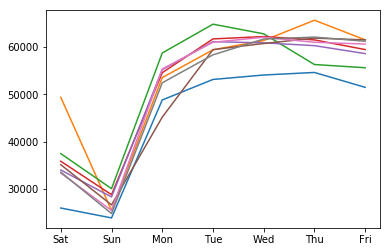

In [29]:
labels = ['Sat', 'Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri']

for week in week_count_list:
    plt.plot(week)
    plt.xticks(range(len(labels)), labels)

In [ ]:
#Sum total ridership for each station over multiple weeks and sort the ridership in ascending order.

In [30]:
stations_totals = stations_daily_totals.groupby('STATION_LINENAME')['ENTRY_COUNTS'].sum().reset_index()

stations_totals.head()

,STATION_LINENAME,ENTRY_COUNTS
0,1 AV L,1130919.0
1,103 ST 1,653428.0
2,103 ST 6,697156.0
3,103 ST BC,239476.0
4,103 ST-CORONA 7,1032524.0


In [31]:
stations_totals = stations_totals.sort_values(['ENTRY_COUNTS'], ascending = False)

stations_totals.head()

,STATION_LINENAME,ENTRY_COUNTS
298,GRD CNTRL-42 ST 4567S,7014381.0
83,34 ST-HERALD SQ BDFMNQRW,6098006.0
26,14 ST-UNION SQ 456LNQRW,5565998.0
289,FULTON ST 2345ACJZ,4445449.0
96,42 ST-PORT AUTH 1237ACENQRSW,4381790.0


In [ ]:
#Now visualize the results.

In [32]:
total_ridership_counts = stations_totals['ENTRY_COUNTS'].tolist()

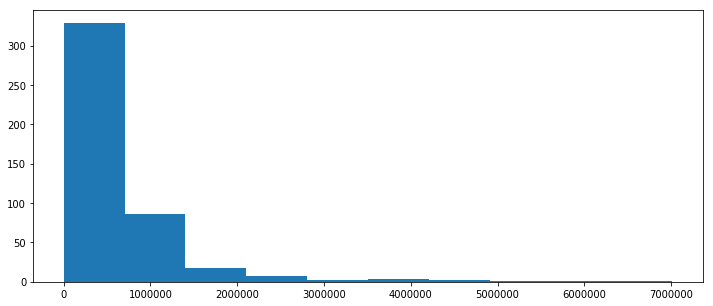

In [33]:
plt.figure(figsize=(12,5))
plt.hist(total_ridership_counts);

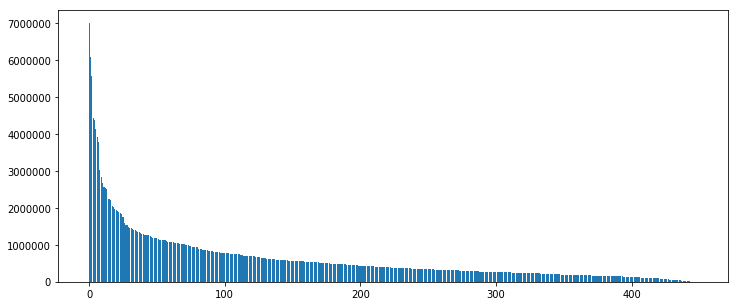

In [34]:
plt.figure(figsize=(12,5))
indices = range(len(total_ridership_counts))
plt.bar(indices, total_ridership_counts);